## Short-term SMA crossover research

Author: Krzysztof Gorczakowski - https://github.com/gorczakowski

Some simplified research into the profitability of short-term SMA crossover strategy

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

def public_request(url, payload={}):
    endpoint = 'https://api.binance.com'
    req = requests.get(endpoint+url, params=payload)
    return req

symbol = 'BTCUSDT'
interval = '1h'
limit = 500

kline_url = '/api/v3/klines'
kline_payload = {'symbol': symbol, 'interval': interval, 'limit': limit}

r = public_request(kline_url, payload=kline_payload).json()

In [2]:
columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'n_o_t', 't_b_vol', 't_b_quote_vol', 'ign']

df = pd.DataFrame(r, columns=columns)

df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')

df = df.drop(columns=df.loc[:, 'volume':'ign'].columns)
df.set_index('open_time', inplace=True)
df = df.astype(float)
df

,open,high,low,close
open_time,,,,
2020-05-04 01:00:00,8806.22,8836.42,8630.55,8693.71
2020-05-04 02:00:00,8693.76,8780.41,8672.67,8746.70
2020-05-04 03:00:00,8746.70,8768.75,8701.00,8730.84
2020-05-04 04:00:00,8730.85,8741.99,8621.00,8687.87
2020-05-04 05:00:00,8688.04,8695.95,8522.00,8606.11
...,...,...,...,...
2020-05-24 16:00:00,9055.60,9055.61,8853.21,8939.12
2020-05-24 17:00:00,8938.11,8989.83,8924.68,8947.84
2020-05-24 18:00:00,8947.84,8982.14,8890.41,8941.99


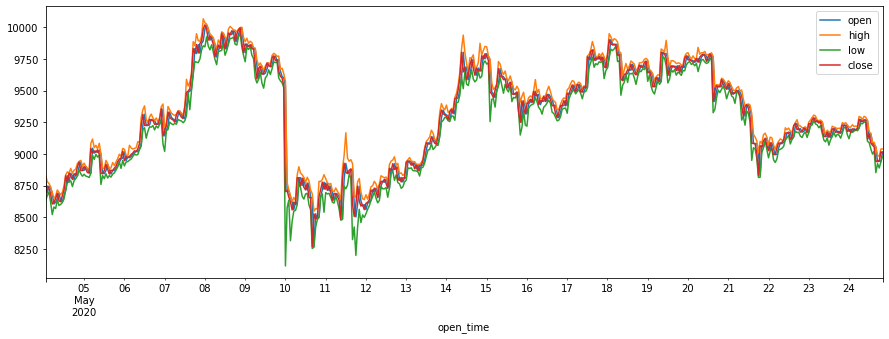

In [3]:
df.plot(figsize=(15,5));

In [4]:
df['hlc'] = (df['high'] + df['low'] + df['close']) / 3
df['sma3'] = df['close'].rolling(3).mean()
# df['sma3'].plot(figsize=(12,8))

df.loc[df['hlc'] > df['sma3'] * 1.005, 'signal_long'] = 1
df.loc[df['hlc'] < df['sma3'] * 0.995, 'signal_short'] = 1

df

,open,high,low,close,hlc,sma3,signal_long,signal_short
open_time,,,,,,,,
2020-05-04 01:00:00,8806.22,8836.42,8630.55,8693.71,8720.226667,NaN,NaN,NaN
2020-05-04 02:00:00,8693.76,8780.41,8672.67,8746.70,8733.260000,NaN,NaN,NaN
2020-05-04 03:00:00,8746.70,8768.75,8701.00,8730.84,8733.530000,8723.750000,NaN,NaN
2020-05-04 04:00:00,8730.85,8741.99,8621.00,8687.87,8683.620000,8721.803333,NaN,NaN
2020-05-04 05:00:00,8688.04,8695.95,8522.00,8606.11,8608.020000,8674.940000,NaN,1.0
...,...,...,...,...,...,...,...,...
2020-05-24 16:00:00,9055.60,9055.61,8853.21,8939.12,8949.313333,9021.636667,NaN,1.0
2020-05-24 17:00:00,8938.11,8989.83,8924.68,8947.84,8954.116667,8980.900000,NaN,NaN
2020-05-24 18:00:00,8947.84,8982.14,8890.41,8941.99,8938.180000,8942.983333,NaN,NaN


In [5]:
def backtest(df, long_only=False):
    pcts = []
    long_price = []
    short_price = []
    prev_price = None
    position = None

    for index, row in df.iterrows():
        if position == 'long' and row['signal_short'] == 1:
            pcts.append(row['hlc'] / prev_price - 1)
            position = None
            short_price.append((index, row['hlc']))
        elif position == 'short' and row['signal_long'] == 1:
            pcts.append(prev_price / row['hlc'] - 1)
            position = None
            long_price.append((index, row['hlc']))

        if position != 'long' and row['signal_long'] == 1:
            prev_price = row['hlc']
            position = 'long'
            long_price.append((index, row['hlc']))
        elif not long_only and position != 'short' and row['signal_short'] == 1:
            prev_price = row['hlc']
            position = 'short'
            short_price.append((index, row['hlc']))

    return pcts, long_price, short_price

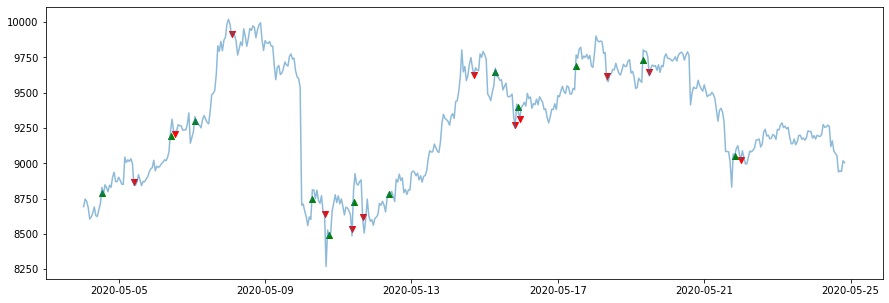

In [6]:
test, longs, shorts = backtest(df, long_only=True)

long_index = [i[0] for i in longs]
long_price = [i[1] for i in longs]

short_index = [i[0] for i in shorts]
short_price = [i[1] for i in shorts]

plt.figure(figsize=(15,5))
plt.plot(df.index, df.close, alpha=0.5)
plt.scatter(long_index, long_price, c='green', marker='^')
plt.scatter(short_index, short_price, c='red', marker='v')
plt.show()

In [7]:
fee = 0.001 # Binance tier 0 fee (0.1%) for maker/taker

# no stoploss
cap = 1
for i in test:
    cap *= (1 + i - fee)

print(len(test), 'trades in', df.index[-1] - df.index[0])
print()
print('Endcap without stoploss:', cap)
print(f'Profit: {round((cap-1)*100,3)}%')
print()

# stoploss at 2%
stoploss = -0.02
test = [i if i > stoploss else stoploss for i in test]
cap = 1
for i in test:
    cap *= (1 + i - fee)

print('Endcap with stoploss:', cap)
print(f'Profit: {round((cap-1)*100,3)}%')

12 trades in 20 days 19:00:00

Endcap without stoploss: 1.067682217730741
Profit: 6.768%

Endcap with stoploss: 1.088966508096001
Profit: 8.897%
